# Separate three donuts using a multilayer perceptron

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

In [3]:
np.random.seed(3)

In [4]:
from lib.mlp import MLP

## Generate data

In [5]:
def donut(r_min, r_max, size):
    rs = np.random.uniform(r_min, r_max, size)
    thetas = np.random.uniform(0, 2 * np.pi, size)

    x1 = np.array([r * np.cos(theta) for r, theta in zip(rs, thetas)])
    x2 = np.array([r * np.sin(theta) for r, theta in zip(rs, thetas)])

    x = np.vstack([x1, x2])
    
    return x

In [6]:
# Numbers of data points
N1 = 120
N2 = 220
N3 = 320

# Clusters of data
x1 = donut(1, 2, N1)
x2 = donut(4, 5, N2)
x3 = donut(7, 8, N3)

# Labels
y1 = np.array([[0] * N1])
y2 = np.array([[0.5] * N2])
y3 = np.array([[1] * N3])

In [7]:
# Put clusters together
N = N1 + N2 + N3
x = np.concatenate([x1, x2, x3], axis=1)
y = np.concatenate([y1, y2, y3], axis=1)

# Shuffle dataset
index = list(np.random.permutation(N))
x = x[:, index]
y = y[:, index]

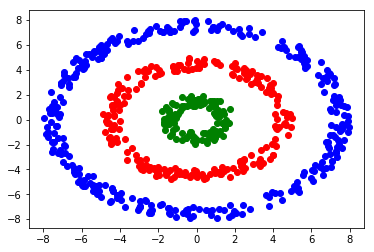

In [8]:
label_colors = {0: 'g', 0.5: 'r', 1: 'b'}

for label, color in label_colors.items():
    is_that_label = y[0] == label
    plt.plot(*x[:, is_that_label], 'o' + color)

## Fit data

In [9]:
# Plot data in foreground, predictions in background
def plot_predictions(x, y, model, zoom_out_ratio=1.1):

    # Find data bounds
    x1_min, x2_min = x.min(axis=1)
    x1_max, x2_max = x.max(axis=1)

    x1_range = x1_max - x1_min
    x2_range = x2_max - x2_min

    # Enlarge data bounds for prettier plotting
    x1_min -= (zoom_out_ratio - 1) * x1_range
    x1_max += (zoom_out_ratio - 1) * x1_range
    x2_min -= (zoom_out_ratio - 1) * x2_range
    x2_max += (zoom_out_ratio - 1) * x2_range

    # Size of the background (i.e. number of pixels)
    background_width = 100
    background_height = 100
    background = np.ones(shape=(background_height, background_width))

    # Generate adequate colormap for the background
    w = [(1, 1, 1)]
    g = [(0.3, 1, 0.3)]
    r = [(1, 0.3, 0.3)]
    b = [(0.3, 0.3, 1)]
    colors = g * 5 + w + r * 5 + w + b * 5
    cm = LinearSegmentedColormap.from_list('rgb', colors, 1000)
    plt.register_cmap(cmap=cm)
    
    # Generate background
    x1_vals = np.linspace(x1_min, x1_max, num=background_width)
    x2_vals = np.linspace(x2_min, x2_max, num=background_height)
    for i, x1_val in enumerate(x1_vals):
        for j, x2_val in enumerate(x2_vals):
            # Convert plot coordinates (i, j) to image coordinates (img_i, img_j)
            img_i = (background_height - 1) - j
            img_j = i
            # Compute backgroup pixel value
            background[img_i, img_j] = model.predict(np.array([[x1_val, x2_val]]).T)

    # Plot background. `coolwarm_r` is a colormap for which 0 -> red and 1 -> blue.
    fig, ax = plt.subplots()
    ax.imshow(background, extent=[x1_min, x1_max, x2_min, x2_max],
              cmap='rgb')

    # Plot data. Use the same color code as the background.
    for label, color in label_colors.items():
        is_that_label = y[0] == label
        plt.plot(*x[:, is_that_label], 'wo', markersize=4)
        plt.plot(*x[:, is_that_label], 'o' + color, markersize=3)
    return fig

epoch 10, error = 0.073


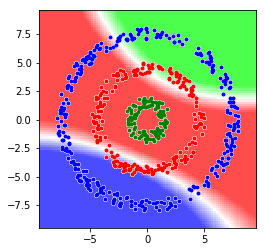

epoch 25, error = 0.072


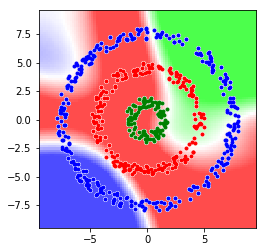

epoch 45, error = 0.068


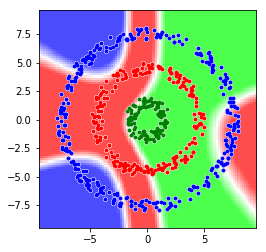

epoch 65, error = 0.034


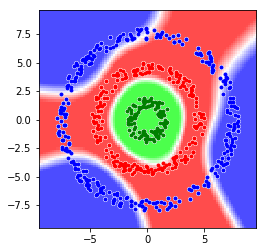

epoch 80, error = 0.006


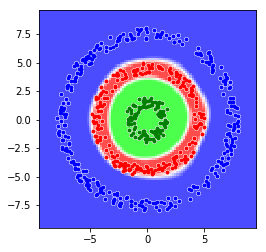

In [10]:
mlp = MLP(layers=[2, 10, 10, 10, 1])

cum_epochs = 0

imgs = []

for epochs in [10, 15, 20, 20, 15]:

    error = mlp.fit(x, y, epochs, batch_size=100, eta=3)
    cum_epochs += epochs

    print('epoch %i, error = %.3f' % (cum_epochs, error))
    plot_predictions(x, y, mlp, zoom_out_ratio=1.1)
    plt.show()